<a href="https://colab.research.google.com/github/TakuInada/umcuEpi_longterm_ieeg_respect_bids/blob/master/time_resolvedPAC_BrainstormTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time-resolved PAC

number of times 5120


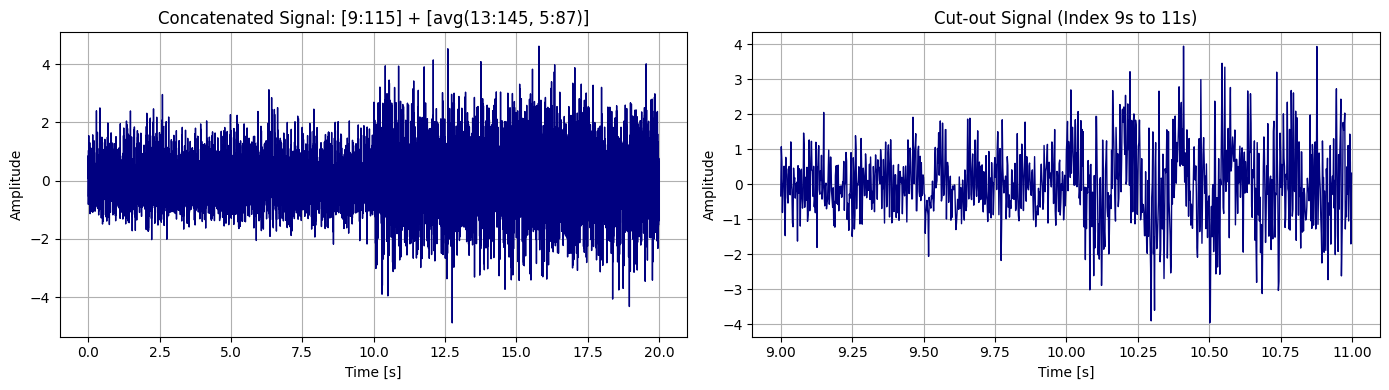

In [10]:
# Artificial signal
import numpy as np
import matplotlib.pyplot as plt
!pip install tensorpac
from tensorpac import Pac
from tensorpac.utils import PSD
from tensorpac.signals import pac_signals_tort
from tensorpac.signals import pac_signals_wavelet

# Sampling settings
sf = 512          # Sampling rate
duration = 10      # Seconds
n_epochs = 20     # Number of Epochs
n_times = int(duration * sf)
print("number of times", n_times)

# 作成するPACの詳細
snr_noise = 0.5   # noiseの強さ（小さいほどSNR高）

# 3つのPACモードの合成信号を生成
signal1, time = pac_signals_wavelet(f_pha=[6, 12], f_amp=[100, 130],
                                 noise=snr_noise, pp=270, rnd_state=0, sf=sf,
                                 n_times=n_times, n_epochs=n_epochs)

signal2a, _ = pac_signals_wavelet(f_pha=[10, 16], f_amp=[125, 165], noise=snr_noise,
                                  pp=0, rnd_state=0, sf=sf,
                                 n_times=n_times, n_epochs=n_epochs)

signal2b, _ = pac_signals_wavelet(f_pha=5, f_amp=87, noise=snr_noise,
                                  pp=180, rnd_state=0, sf=sf,
                                 n_times=n_times, n_epochs=n_epochs)

# 合成（平均 or 単純和）して時系列として「signal1」と「combined_signal2」を縦に繋
combined_signal2 = (signal2a[0] + signal2b[0])
stacked_signal = np.concatenate([signal1[0], combined_signal2])
stacked_time = np.arange(0, stacked_signal.size) / sf

# 可視化
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(stacked_time, stacked_signal, lw=1, color='navy')
plt.title('Concatenated Signal: [9:115] + [avg(13:145, 5:87)]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)

# Cut out the data from index 9 to 11 (inclusive)
cut_time = stacked_time[9*sf:11*sf]  # Indices 9, 10, 11 are included
cut_signal = stacked_signal[9*sf:11*sf]

# Plot the cut-out data in the second subplot
plt.subplot(1, 2, 2)
plt.plot(cut_time, cut_signal, lw=1, color='navy')
plt.title('Cut-out Signal (Index 9s to 11s)')  # Updated title
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

Compute PSD over 1 trials and 10240 time points
INFO:tensorpac:Compute PSD over 1 trials and 10240 time points
    Add 95th confidence interval
INFO:tensorpac:    Add 95th confidence interval
<ipython-input-11-6ab17a38228e>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  psd.plot(confidence=95, f_min=1, f_max=180, log=False, grid=True, fz_title=12, fz_labels=10)


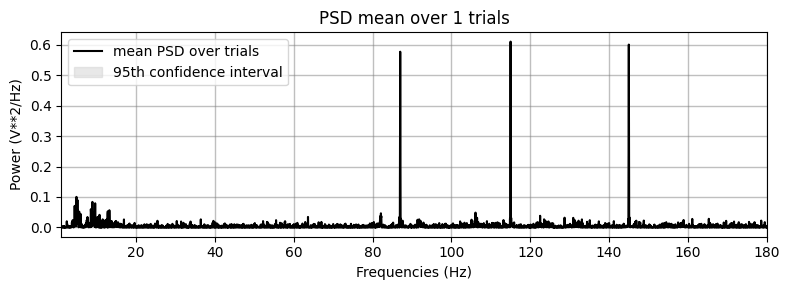

In [11]:
data = stacked_signal.reshape(1, -1) # reshape to (1, n_times)
psd = PSD(data, sf)

plt.figure(figsize=(8, 3))
# The 'basex' argument is deprecated
psd.plot(confidence=95, f_min=1, f_max=180, log=False, grid=True, fz_title=12, fz_labels=10)
plt.tight_layout()

Phase Amplitude Coupling object defined
INFO:tensorpac:Phase Amplitude Coupling object defined


PAC method:  Gaussian Copula PAC (gcPac)
Surrogates: Swap amplitude time blocks (Bahramisharif et al. 2013)
Normalization: Substract the mean of surrogates


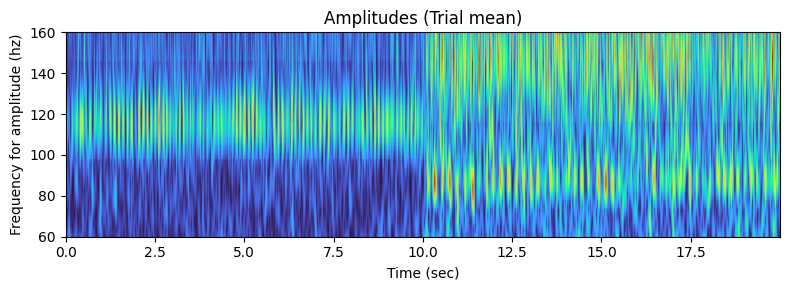

In [18]:
# Define a Pac object
p = Pac(idpac=(6, 2, 1), f_pha='hres', f_amp='hres')

print("PAC method: ", p.method)
print("Surrogates:", p.str_surro)
print("Normalization:", p.str_norm)
# extract all of the phases and amplitudes
phases = p.filter(sf, data, ftype='phase', n_jobs=1)
amplitudes = p.filter(sf, data, ftype='amplitude', n_jobs=1)
f_amp, f_pha = np.mean(p.f_amp, 1), np.mean(p.f_pha, 1)

plt.figure(figsize=(8, 3))
plt.title("Amplitudes (Trial mean)")
# Replace 'stacked_time' with stacked_time[-1] or duration
plt.imshow(np.mean(amplitudes, 1)[::-1], cmap="turbo", extent=(0,stacked_time[-1],f_amp[0],f_amp[-1]), aspect='auto')
plt.xlabel("Time (sec)"); plt.ylabel('Frequency for amplitude (hz)')
plt.tight_layout()

    extract phases (n_pha=50) and amplitudes (n_amps=50)
INFO:tensorpac:    extract phases (n_pha=50) and amplitudes (n_amps=50)
    true PAC estimation using Gaussian Copula PAC (gcPac)
INFO:tensorpac:    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=3291)
INFO:tensorpac:    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=3291)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean of surrogates)
INFO:tensorpac:    normalize true PAC estimation by surrogates (Substract the mean of surrogates)
    infer p-values at (p=0.05, mcp=maxstat)
INFO:tensorpac:    infer p-values at (p=0.05, mcp=maxstat)


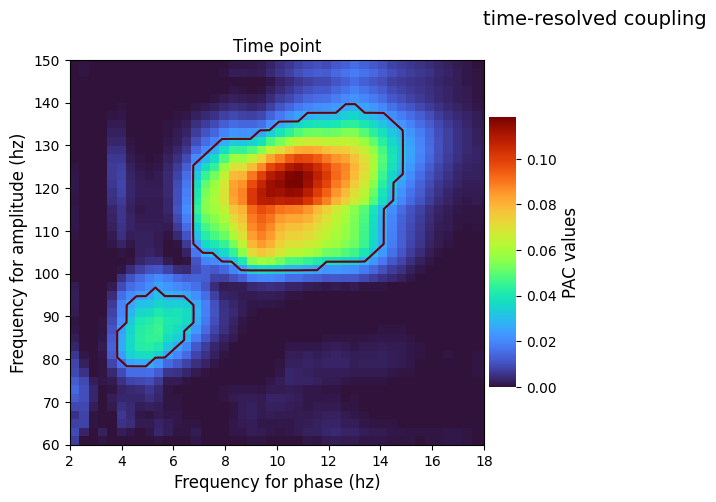

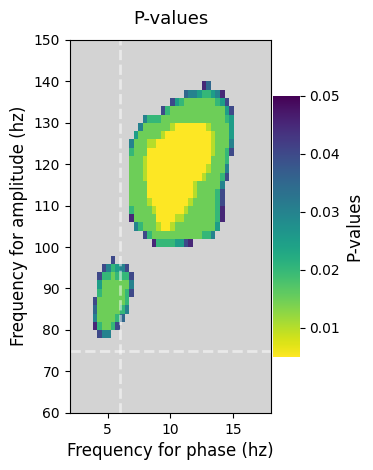

In [21]:
# Fileter the data and extract pac
n_perm = 200 # > 1/0.05
xpac = p.filterfit(sf, data, n_perm=n_perm, n_jobs=-1).squeeze()
pval = p.infer_pvalues(p=0.05) # get the corrected p-values

plt.figure(figsize=(14, 5))
plt.suptitle("time-resolved coupling", fontsize=14)
plt.subplot(1,2,1)
# Plot your comodulogram
p.comodulogram(xpac, title=p.method,
              cmap="turbo", vmin=0, pvalues=pval, levels=.05)
plt.xlim(2, 18)
plt.ylim(60, 150)
plt.title("Time point")  # Add a title for each subplot
plt.show()  # Show each subplot separately

plt.subplot(1,2,2)
p.comodulogram(pval, title='P-values', cblabel='P-values', cmap='viridis_r', vmin=1. / n_perm,
               vmax=.05, over='lightgray')
plt.axvline(x=6, color="white", linestyle="dashed", linewidth=2, alpha=0.5)
plt.axhline(y=75, color="white", linestyle="dashed", linewidth=2, alpha=0.5)
plt.xlim(2, 18)
plt.ylim(60, 150)
plt.tight_layout()